In [ ]:
# data from https://www.kaggle.com/sengzhaotoo/movielens-small
# https://yeomko.tistory.com/8 참고

In [ ]:
# als를 직접 구현해보자
# 데이터는 kaggle에서 movicelens 데이터를 가져옴..

In [76]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

## data load

In [2]:
# 다른 csv파일도 있지만 둘만 있어도 충분.
ratings = pd.read_csv("./data/ratings.csv")
movies = pd.read_csv("./data/movies.csv")

In [3]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.shape, ratings.shape

((9125, 3), (100004, 4))

In [8]:
# 필요없는 column drop
ratings.drop(labels = "timestamp", axis = 1, inplace = True)
movies.drop(labels = "genres", axis = 1, inplace = True)

In [10]:
# 평점 데이터와 영화 데이터를 merge
total_df = pd.merge(left = ratings, right = movies, on = "movieId")
total_df.head()

,userId,movieId,rating,title
0,1,31,2.5,Dangerous Minds (1995)
1,7,31,3.0,Dangerous Minds (1995)
2,31,31,4.0,Dangerous Minds (1995)
3,32,31,4.0,Dangerous Minds (1995)
4,36,31,3.0,Dangerous Minds (1995)


In [19]:
user_movie = total_df.pivot_table(values = "rating",
                                  index = "userId",
                                  columns = "movieId",
                                  fill_value = 0)

In [22]:
user_movie.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


In [23]:
user_movie.shape

(671, 9066)

In [24]:
user_num = user_movie.shape[0]
movie_num = user_movie.shape[1]

user_num, movie_num

(671, 9066)

## variable setting

In [27]:
latent_num = 200
r_lambda = 40
alpha = 40

In [31]:
# X, Y를 랜덤한 작은값들로 초기화

X = np.random.rand(user_num, latent_num) * 1e-2
Y = np.random.rand(movie_num, latent_num) * 1e-2

R = user_movie.to_numpy()

## P setting

<img src = "./p.png">

In [36]:
P = np.copy(R)
P[P > 0] = 1

## C setting

<img src = "./c.png">

In [38]:
C = 1 + alpha * R

In [62]:
C.shape

(671, 9066)

## loss function setting

<img src = "./loss_function.png">

In [48]:
def loss(C, P, XtY, X, Y, r_lambda) :
    error = np.square(P - XtY)
    confidence_error = np.sum(C * error)
    
    reg = (np.sum(np.square(X)) + np.sum(np.square(Y))) * r_lambda
    
    total = confidence_error + reg
    
    return np.sum(error), confidence_error, reg, total

##  Optimizer 설정

<img src = "./x.png">

In [63]:
def optimize_user(X, Y, C, P, user_num, latent_num, r_lambda) :
    Yt = np.transpose(Y)
    
    for num in range(user_num) :
        Cu = np.diag(C[num])
        Yt_Cu_Y = np.matmul(np.matmul(Yt, Cu), Y)
        lambda_I = r_lambda * np.identity(latent_num)
        Yt_Cu_Pu = np.matmul(np.matmul(Yt, Cu), P[num])
        
        X[num] = np.linalg.solve(Yt_Cu_Y + lambda_I, Yt_Cu_Pu)

<img src = "./y.png">

In [67]:
def optimize_item(X, Y, C, P, movie_num, latent_num, r_lambda) :
    Xt = np.transpose(X)
    
    for num in range(movie_num) :
        Ci = np.diag(C[:, num])
        Xt_Ci_X = np.matmul(np.matmul(Xt, Ci), X)
        lambda_I = r_lambda * np.identity(latent_num)
        Xt_Ci_Pi = np.matmul(np.matmul(Xt, Ci), P[:, num])
        
        Y[num] = np.linalg.solve(Xt_Ci_X + lambda_I, Xt_Ci_Pi)

## Train

In [68]:
predict_errors = []
confidence_errors = []
reg_list = []
total_losses = []

for i in range(15) :
    # i == 0 일때는 그냥 가고.. 1일때부터 학습..?
    if i != 0 :
        optimize_user(X, Y, C, P, user_num, latent_num, r_lambda)
        optimize_item(X, Y, C, P, movie_num, latent_num, r_lambda)
        
    predict = np.matmul(X, np.transpose(Y))
    
    predict_error, confidence_error, reg, total_loss = loss(C, P, predict, X, Y, r_lambda)
    
    predict_errors.append(predict_error)
    confidence_errors.append(confidence_error)
    reg_list.append(reg)
    total_losses.append(total_loss)
    
    print("======= step {} =======".format(i))
    print("predict error : {}".format(predict_error))
    print("confidence error : {}".format(confidence_error))
    print("reg : {}".format(reg))
    print("total loss : {}".format(total_loss))
    
final_predict = np.matmul(X, np.transpose(Y))

print("final predict")
print(final_predict)

======= step 0 =======
predict error : 1333366.2014464051
confidence error : 3563638.4142755624
reg : 1221467.0294828091
total loss : 4785105.443758371
======= step 1 =======
predict error : 517086.82278555183
confidence error : 807717.8028674035
reg : 1610911.4731685899
total loss : 2418629.2760359934
======= step 2 =======
predict error : 122022.98008618885
confidence error : 150837.5505695427
reg : 465507.6249070496
total loss : 616345.1754765923
======= step 3 =======
predict error : 88182.42921312885
confidence error : 106935.6211828214
reg : 373961.22083851596
total loss : 480896.84202133736
======= step 4 =======
predict error : 76111.84568814546
confidence error : 91389.90868186843
reg : 347612.55084078637
total loss : 439002.45952265477
======= step 5 =======
predict error : 70253.75899180664
confidence error : 83716.63302775504
reg : 336412.843075591
total loss : 420129.4761033461
======= step 6 =======
predict error : 66917.04476636069
confidence error : 79247.55669731356
re

In [70]:
final_predict.shape

(671, 9066)

In [75]:
final_predict[1, 9]

0.9879184540050803

In [69]:
user_movie

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,4.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
5,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
668,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0
669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,...,0.0,0.0,0,0,0.0,0,0.0,0,0,0


In [117]:
pd.DataFrame(data = final_predict, index = user_movie.index, columns = user_movie.columns)

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,-0.074265,-0.015372,0.063132,-0.120114,-0.064491,-0.010983,0.125556,-0.073351,0.035380,0.029563,...,-0.003213,0.005833,0.021442,-0.002009,-0.002031,-0.000142,0.021526,0.060334,0.057759,-0.003227
2,0.601867,0.668466,0.070548,0.353690,0.353868,0.573413,0.182496,0.074222,0.080589,0.987918,...,0.006512,0.010668,-0.007700,-0.002558,-0.002586,-0.026683,-0.007730,-0.052719,-0.050469,0.006540
3,0.394245,-0.008371,0.064389,-0.038671,0.189853,0.211753,-0.106935,-0.032082,-0.054146,0.214809,...,0.000101,-0.011686,0.004611,0.001505,0.001521,0.007228,0.004629,0.090151,0.086304,0.000101
4,0.332705,0.436296,0.161681,0.021380,-0.105250,0.227790,0.088606,-0.028386,0.031675,0.987012,...,0.008029,-0.001677,0.031043,0.009475,0.009578,0.056694,0.031163,-0.100467,-0.096179,0.008063
5,0.731502,0.623446,0.956674,-0.044947,0.423281,0.314046,0.196507,0.039423,-0.033979,0.104945,...,-0.004553,-0.016002,0.000759,-0.000900,-0.000910,0.000972,0.000762,0.077042,0.073754,-0.004572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.752508,0.585095,0.248867,0.403660,0.307856,0.976064,0.297459,0.083180,0.232453,0.869803,...,-0.000486,0.003830,-0.000508,0.000050,0.000051,-0.016380,-0.000510,-0.003202,-0.003066,-0.000488
668,0.097127,0.089135,0.072340,-0.121451,-0.208853,-0.127288,-0.109774,-0.029678,-0.121537,-0.054377,...,-0.001487,0.005561,-0.002947,-0.001788,-0.001808,0.016648,-0.002959,-0.029544,-0.028283,-0.001493
669,0.162213,-0.005728,-0.045687,0.148665,0.027252,0.152812,-0.054934,0.031648,0.174553,0.198883,...,0.005216,0.001999,-0.000031,0.001711,0.001730,-0.006948,-0.000031,0.011190,0.010712,0.005238


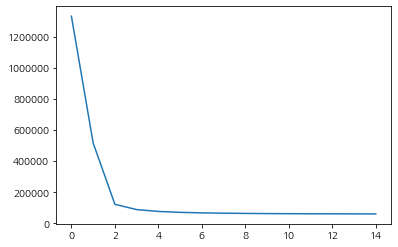

In [77]:
plt.plot(predict_errors)

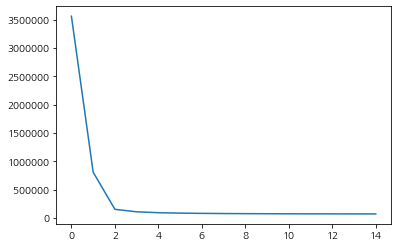

In [78]:
plt.plot(confidence_errors)

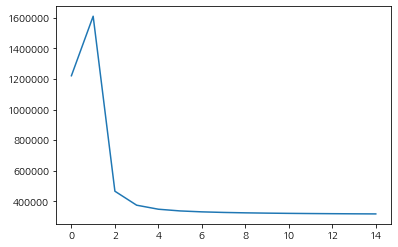

In [79]:
plt.plot(reg_list)

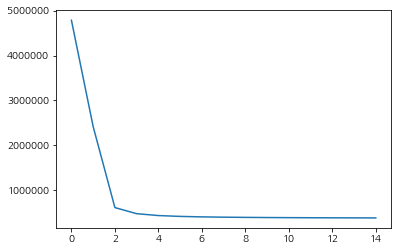

In [80]:
plt.plot(total_losses)

In [ ]:
# surprise라는 패키지에 추천시스템 알고리즘이 있다..?